# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_excel('geo_comment.xlsx', index_col=0)
data

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...
...,...,...,...,...,...
70377,37.454528,55.792331,-1,1,Не поддерживаю. Я против строительства многоэт...
70378,37.384325,55.899068,-1,1,Не поддерживаю. Не нужны отстойники автобусов ...
70379,37.421066,55.848756,1,1,"Не поддерживаю. На мой взгляд, необходимо искл..."
70380,37.448509,55.793065,-1,1,Не поддерживаю: нарушения при строительстве н...


<AxesSubplot:xlabel='x', ylabel='y'>

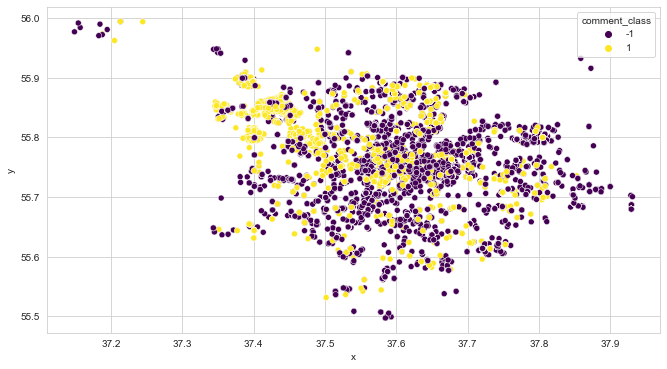

In [3]:
#Общее распределение голосов за и против
plt.figure(figsize=(11, 6))
sns.set_style('whitegrid')

sns.scatterplot(data=data, x = 'x', y = 'y', hue='comment_class', palette='viridis')

In [4]:
data.multiplier.describe()

count    70382.000000
mean         1.545935
std         16.986786
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1500.000000
Name: multiplier, dtype: float64

In [5]:
data.groupby([data.x, data.y]).count().sort_values(by='comment', ascending=False)

,,comment_class,multiplier,comment
x,y,,,
37.442095,55.883792,7338,7338,7338
37.454528,55.792331,3616,3616,3616
37.685934,55.751193,2960,2960,2960
37.805293,55.799532,2816,2816,2816
37.570887,55.741389,2804,2804,2804
...,...,...,...,...
37.573905,55.900057,1,1,1
37.573887,55.739037,1,1,1
37.573717,55.763852,1,1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              70382 non-null  float64
 1   y              70382 non-null  float64
 2   comment_class  70382 non-null  int64  
 3   multiplier     70382 non-null  int64  
 4   comment        70382 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


In [7]:
silent_data = data[['x', 'y', 'comment_class']]
silent_data

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1
...,...,...,...
70377,37.454528,55.792331,-1
70378,37.384325,55.899068,-1
70379,37.421066,55.848756,1
70380,37.448509,55.793065,-1


In [8]:
#В данных много повторяющихся координат, от них надо избавиться. Поскольку для дальнейших заданий голоса важны, от колонки
# comment_class избавляться пока не буду
silent_data.drop_duplicates(inplace=True)
silent_data

C:\Users\Solnotka\anaconda3\envs\env_3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,x,y,comment_class
0,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1
7,37.558957,55.723399,-1
...,...,...,...
70366,37.407465,55.757977,1
70367,37.471488,55.668346,-1
70368,37.674490,55.633043,1
70369,37.670672,55.630924,1


<AxesSubplot:>

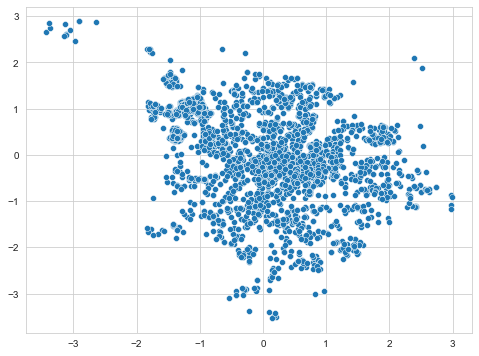

In [9]:
#Стандартизация
X = silent_data[['x', 'y']]
X_scaled = StandardScaler().fit_transform(X)

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')

sns.scatterplot(x = X_scaled[:, 0], y = X_scaled[:, 1])

In [10]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=16),
    AgglomerativeClustering(n_clusters=16),
    DBSCAN(eps = 0.15),
]

C:\Users\Solnotka\anaconda3\envs\env_3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


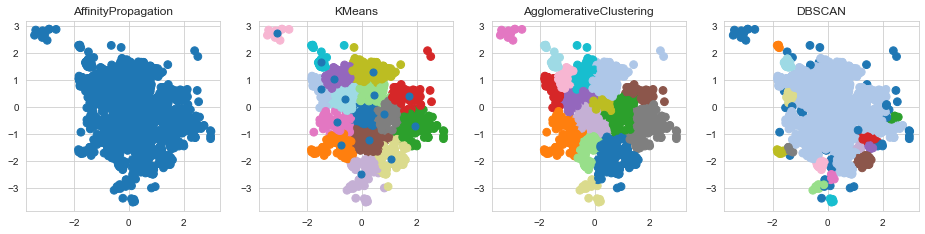

In [11]:
#Графическое представление работы разных алгоритмов кластеризации
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
for ax, algorithm in zip(axes, algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='tab20', s=60)
    ax.set_title(algorithm.__class__.__name__)
    
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

C:\Users\Solnotka\anaconda3\envs\env_3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


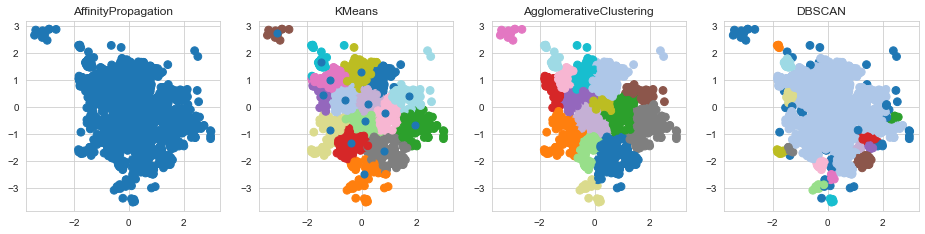

In [12]:
#Кластеризация для голосов против
X_minus = silent_data[['x', 'y']][silent_data['comment_class'] == -1]
X_scaled_minus = StandardScaler().fit_transform(X)

fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
for ax, algorithm in zip(axes, algorithms):
    clusters = algorithm.fit_predict(X_scaled_minus)
    ax.scatter(X_scaled_minus[:, 0], X_scaled_minus[:, 1], c=clusters, cmap='tab20', s=60)
    ax.set_title(algorithm.__class__.__name__)
    
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

C:\Users\Solnotka\anaconda3\envs\env_3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


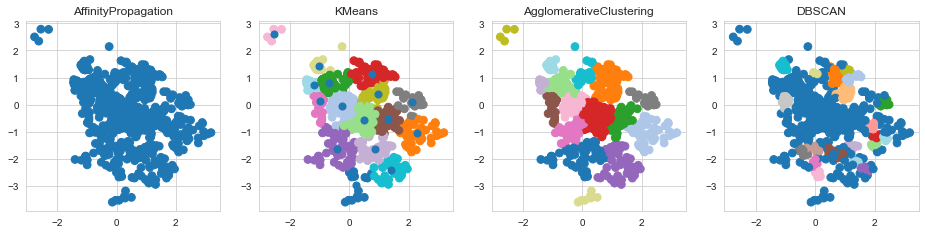

In [13]:
#Кластеризация для голосов за
X = silent_data[['x', 'y']][silent_data['comment_class'] == 1]
X_scaled_plus = StandardScaler().fit_transform(X)

fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
for ax, algorithm in zip(axes, algorithms):
    clusters = algorithm.fit_predict(X_scaled_plus)
    ax.scatter(X_scaled_plus[:, 0], X_scaled_plus[:, 1], c=clusters, cmap='tab20', s=60)
    ax.set_title(algorithm.__class__.__name__)
    
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

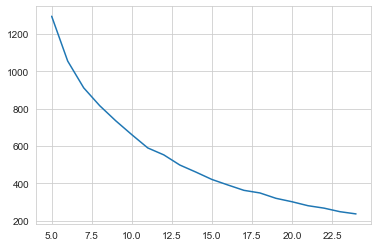

In [14]:
#Поиск оптимального количества кластеров для KMeans
k_inertia = []
ks = range(5,25)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)
plt.plot(ks, k_inertia)

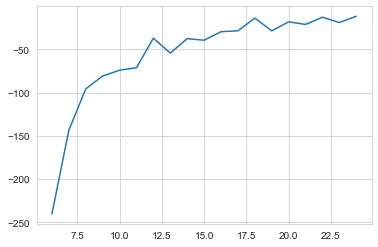

In [15]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

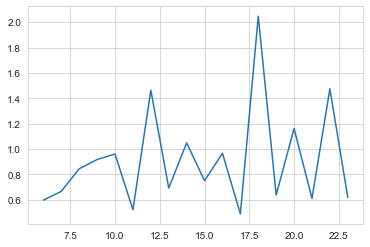

In [16]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [17]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

17

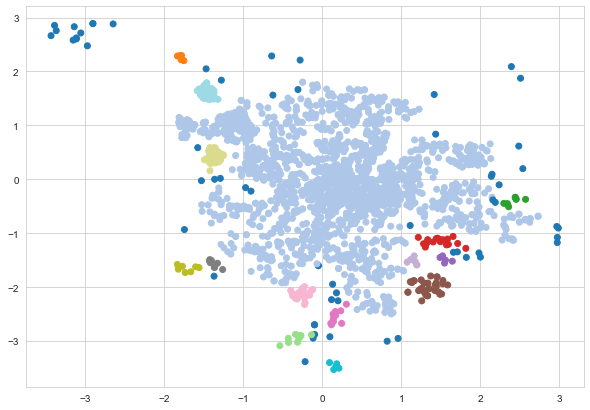

In [18]:
#Для исследования активности районов выбрала KMeans, а не DBSCAN. DBSCAN рассматривает центр города как один общий кластер,
# остальные кластеры крошечные, а это не очень удобно для визуализации.
plt.figure(figsize=(10,7))
y = DBSCAN(eps=0.15).fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='tab20')
plt.show()

In [19]:
set(y)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

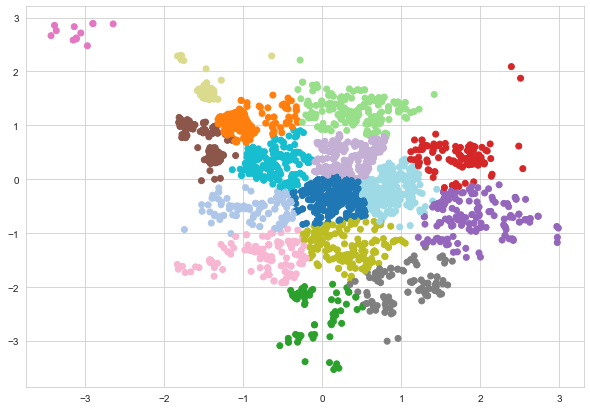

In [20]:
plt.figure(figsize=(10,7))
y = KMeans(n_clusters=16).fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='tab20')
plt.show()

In [21]:
data_active = data[['x', 'y', 'multiplier']]

In [22]:
#Получаю количество голосов для каждого района
data_active_all = data_active.loc[data_active.index.repeat(data_active['multiplier'])].reset_index()
data_active_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   index       108806 non-null  int64  
 1   x           108806 non-null  float64
 2   y           108806 non-null  float64
 3   multiplier  108806 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [23]:
data_active['kmeans'] = KMeans(n_clusters=16).fit_predict(StandardScaler().fit_transform(data_active[['x', 'y']]))
data_for_vis = data_active.groupby(data_active.kmeans).count().sort_values(by='multiplier').reset_index()
data_for_vis

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_16836/4234919190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_active['kmeans'] = KMeans(n_clusters=16).fit_predict(StandardScaler().fit_transform(data_active[['x', 'y']]))


,kmeans,x,y,multiplier
0,14,908,908,908
1,15,1294,1294,1294
2,5,1593,1593,1593
3,11,1817,1817,1817
4,12,2547,2547,2547
5,7,2666,2666,2666
6,13,2767,2767,2767
7,0,3154,3154,3154
8,3,3188,3188,3188
9,6,3885,3885,3885


In [24]:
for_vis = data_active[['x', 'y', 'kmeans']].merge(data_for_vis[['kmeans', 'multiplier']], how='left', on='kmeans')
for_vis

,x,y,kmeans,multiplier
0,37.612416,55.777454,9,6680
1,37.612416,55.777454,9,6680
2,37.603298,55.742108,9,6680
3,37.558526,55.728758,9,6680
4,37.566431,55.731794,9,6680
...,...,...,...,...
70377,37.454528,55.792331,4,7280
70378,37.384325,55.899068,1,8377
70379,37.421066,55.848756,8,4868
70380,37.448509,55.793065,4,7280


In [25]:
for_vis['colour'] = for_vis['multiplier'].apply(lambda x: x // 1000)
for_vis

,x,y,kmeans,multiplier,colour
0,37.612416,55.777454,9,6680,6
1,37.612416,55.777454,9,6680,6
2,37.603298,55.742108,9,6680,6
3,37.558526,55.728758,9,6680,6
4,37.566431,55.731794,9,6680,6
...,...,...,...,...,...
70377,37.454528,55.792331,4,7280,7
70378,37.384325,55.899068,1,8377,8
70379,37.421066,55.848756,8,4868,4
70380,37.448509,55.793065,4,7280,7


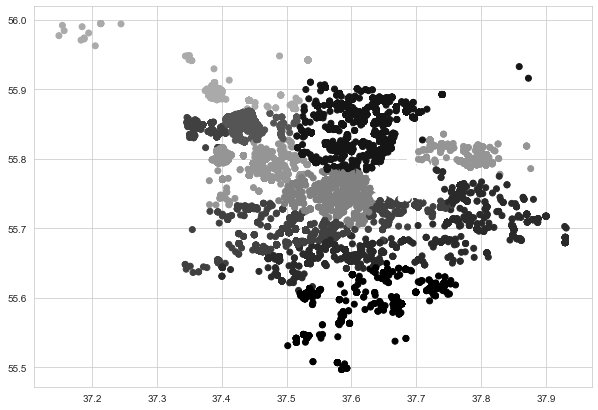

In [26]:
#Собственно визуализация: более активные районы окрашены в более темные цвета
plt.figure(figsize=(10,7))
plt.scatter(for_vis.x, for_vis.y, c=for_vis.colour, cmap='gray')
plt.show()